Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


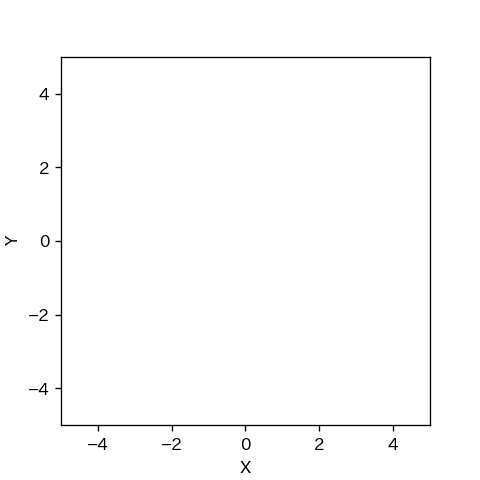

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


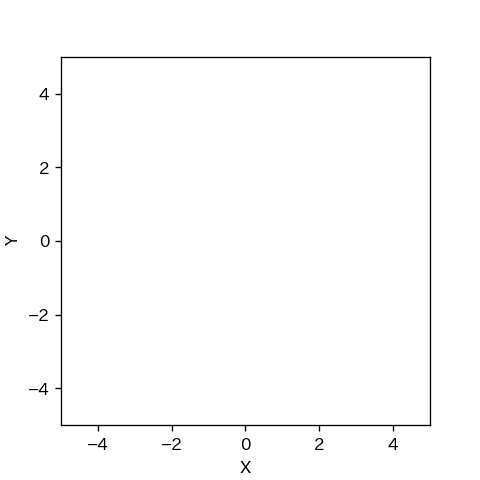

(array([ 1.53905605, -4.21721301,  0.08606291]),
 array([-1.12464738,  3.99315818, -0.49692388]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[1.9653790871685644]
0 真値: [-6.57387697  1.3943599   4.1684679 ] 推定値: [-2.4276527   3.27911745  2.11282209] 誤差: 4.554501809721645
[3.8549044046885226]
1 真値: [-0.8813894   3.1332718   6.71458228] 推定値: [-0.51548843  2.7461271   0.5438602 ] 誤差: 0.5326955409598783
1
[5.017473013369036]
2 真値: [-3.7941729   0.21660649  4.07221175] 推定値: [-3.82255106  0.29914707  3.97543512] 誤差: 0.08728268040343291
2
[4.036841942502463]
3 真値: [-0.73351045 -0.7687625   6.93480371] 推定値: [-1.66430853 -0.23631376  6.7491746 ] 誤差: 1.0723277084119291
[2.893571754664851]
4 真値: [-3.00947072  0.33001122  3.04843852] 推定値: [-2.20050359  2.34127755 -2.05185119] 誤差: 2.1678607178327156
[4.958863687746147]
5 真値: [4.04432129 0.83323207 8.41693678] 推定値: [3.87816953 0.51404556 2.00642963] 誤差: 0.35984223914193597
3
[2.0978287928455477]
6 真値: [-0.02992908  1.34807881  5.27444027] 推定値: [-0.11171233  1.22910471  5.29485548] 誤差: 0.14437221352126228
4
[1.7151061555685083]
[4.940058105762981]
[6.220095905093747]
7 真値: [ 0.54303994 -1.

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[5.1735316474898205]
20 真値: [-2.34043863 -3.25176578  5.05505849] 推定値: [-0.66132828 -2.98837283  6.12108054] 誤差: 1.699643318959055
[5.669647042615325]
21 真値: [-3.85224938 -5.31910457  6.48300651] 推定値: [-11.20485685   2.68693618   4.42382548] 誤差: 10.870028752377147
[2.0443290979359583]
[6.80058958734449]
22 真値: [3.21294043 1.53922366 5.97428832] 推定値: [ 7.37279193 -3.27173978 -1.99848862] 誤差: 6.360010513261326
[5.195586546977932]
23 真値: [ 1.07710561 -2.41057914  3.6487925 ] 推定値: [5.19443157 7.3745656  0.3955505 ] 誤差: 10.616093002889913
[6.599213348180675]
24 真値: [-3.00266838  2.71730242  4.4676126 ] 推定値: [-2.98640804  2.77488841  4.50709962] 誤差: 0.05983765944993476
14
[1.2727189196180788]
25 真値: [ 4.14521401 -2.5708979   1.73544763] 推定値: [ 2.42518038 -3.91121996  7.70151332] 誤差: 2.180591405967048
[2.9104451172837713]
26 真値: [0.07764816 2.32667771 3.37809502] 推定値: [-0.18761493  2.62539805  3.49515326] 誤差: 0.3994976252893698
15
[5.111877718272561]
[2.5487248463947814]
[0.9260072534543543, 